In [1]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit

In [2]:
sys.path.append("C:\\Users\josep\Downloads")

In [3]:
f = h5py.File('C:\\Users\josep\Downloads\data_psi_zero.hdf5', 'r')

In [4]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)

In [5]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Downloads\data_psi_zero.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [6]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 0.5 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.35, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label)
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles)#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

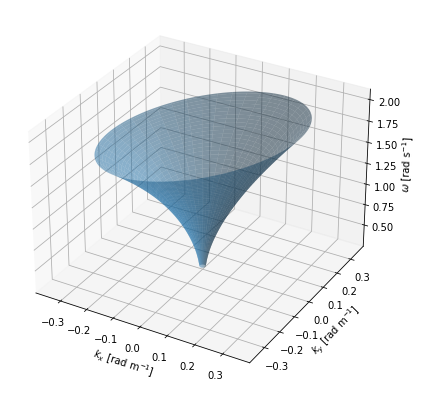

In [7]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=100, z = z, U = U, psi = 0)

In [127]:
def plot_disp_relation_and_points_at_theta(spec_theta, thresh_freq, max_freq, step_size, h, z, U, psi):
    '''
    This function finds the relationship between triplets found from spectrum from FFT 
    and the dispersion relation at specific theta. 
    It plots it in the Radial vs Omega Space. 
    '''
    
    # (1) TRIPLET POINTS
    
    freqs = np.arange(thresh_freq, max_freq, step_size)
    kx_list = []
    ky_list = []

    # This gets the triplets points 
    # Triplets are (max_kx, mak_ky, freqs)
    for f in freqs:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:]-f))
        spec = spec3d.spectrum()
        spec_values = spec[len(t)//2 + i,:,:]
        # Gives the spectrum values represented by colour
    
        max_index = np.unravel_index(np.argmax(spec_values), spec_values.shape)
        # Finds the specific index of the maximum value in spec_values
    
        max_kx = spec3d.kx[max_index[0]]
        max_ky = spec3d.ky[max_index[1]]
        # Finds the value of kx and ky corresponding to the maximum spectral density 
        
        kx_list.append(max_kx)
        ky_list.append(max_ky)
        
    kx = np.array(kx_list)
    ky = np.array(ky_list)
    
    # transform Triplets to polar coordinates
    r = np.sqrt( (kx)**2 + (ky)**2 )
    theta = np.arctan2(ky,kx)
    
    # (2) DISPERSION SURFACE
    axes = fig.add_subplot(111, projection='3d')
    disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h, z, U, psi = 0)
    
    # Convert Dispersion Surface to Polars by first removing mesh grid format
    matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )
    disp_r = matrix_disp_r[:,0]
    
    matrix_disp_theta = np.arctan2(disp_ky,disp_kx)
    disp_theta = matrix_disp_theta[0]
    
    nearest_index = np.argmin(np.abs(disp_theta - spec_theta))
    disp_ww_for_theta = disp_ww[:, nearest_index]
    
    plt.scatter(r, freqs, color = 'red', zorder=1, label = 'Triplets')
    plt.plot(disp_r, disp_ww_for_theta, color='grey',zorder=0, label = 'Dispersion Relation at $\Theta$')
    plt.grid(True)
    plt.xlabel('Radial Distance (r)')
    plt.ylabel('$\omega$')
    plt.title("Dispersion Relation vs Triplets in Radial-Frequency Space")
    plt.legend()
    
    return r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta

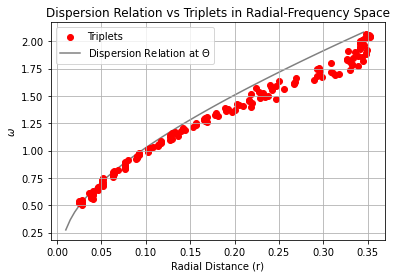

In [128]:
r, theta, freqs, kx, ky, disp_r,disp_ww_for_theta = plot_disp_relation_and_points_at_theta(0, thresh_freq = 0.5 , 
                                                  max_freq = 2.08, step_size = 0.01, h=100, 
                                                  z = z, U=U, psi = 0)

# Past Triplet Distibution 

In [129]:
FFT_spec = spec3d.spectrum()

In [130]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if array[i][j] > threshold:
                indices.append((i, j))
    return indices

In [131]:
def use_triplet_disrtibution(threshold):
    at_w = np.array([1.75])
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        plt.scatter(k_above_energy, np.full_like(k_above_energy, at_w), color = 'red', s = 1)

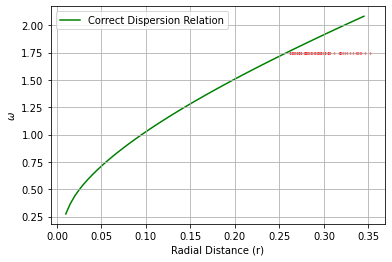

In [132]:
use_triplet_disrtibution(0.1)

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [45]:
def use_triplet_disrtibution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution
    
        threshold   float
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    '''
    
    
    avg_k = []
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        avg_k.append(sum(k_above_energy)/len(k_above_energy))
        
    return avg_k, k_above_energy

In [46]:
test_w = np.array([1.75])


In [48]:
threshie = np.arange(1.9, 2.09, 0.1)

In [49]:
threshie = np.array([1.4, 2])

In [50]:
def find_indices_thresh(array, threshold_array):
    all_indices = []  # stores all indices for all thresholds
    
    for t in threshold_array:
        indices = []
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j] > t:
                    indices.append((i, j))
        all_indices.append(indices)  # Store indices for the current threshold in the list
    
    return all_indices


In [51]:
find_indices_thresh(energies, np.array([1, 2, 3]))

[[(19, 50),
  (21, 52),
  (22, 52),
  (25, 55),
  (26, 55),
  (27, 56),
  (31, 57),
  (32, 57),
  (34, 58),
  (35, 58),
  (36, 58),
  (40, 58),
  (41, 58),
  (43, 58)],
 [(26, 55), (34, 58), (36, 58)],
 [(26, 55), (34, 58)]]

In [52]:
indices = find_indices_thresh(energies, threshie)

In [53]:
indices

[[(21, 52),
  (22, 52),
  (26, 55),
  (31, 57),
  (34, 58),
  (35, 58),
  (36, 58),
  (40, 58)],
 [(26, 55), (34, 58), (36, 58)]]

In [54]:
indices[0][0][0]

21

In [55]:
indices[0][1][0]

22

In [56]:
indices[0][2][0]

26

In [57]:
spec3d

In [58]:
def calculate_k(indices):
    k_values = []
    for sublist in indices:
        k_sublist = []
        for i, j in sublist:
            k = np.sqrt(spec3d.kx[i]**2 + spec3d.ky[j]**2)
            k_sublist.append(k)
        k_values.append(k_sublist)
    return k_values

# Calculate k values
k_values = calculate_k(indices)
k_values

[[0.2852465224580893,
  0.27867511469496364,
  0.2930476708429552,
  0.3056952328585095,
  0.3175863558794404,
  0.31834643599937157,
  0.31960921936228254,
  0.3295373293032112],
 [0.2930476708429552, 0.3175863558794404, 0.31960921936228254]]

In [59]:
average_values = [sum(inner) / len(inner) for inner in k_values]

# Print the result
for i, avg in enumerate(average_values):
    print(avg)

0.3059679851748529
0.31008108202822604


In [60]:
def find_indices_multi_thresh(array, threshold_array):
    all_indices = []  # stores all indices for all thresholds
    
    for t in threshold_array:
        indices = []
        for i in range(len(array)):
            for j in range(len(array[i])):
                if array[i][j] > t:
                    indices.append((i, j))
        all_indices.append(indices)  # Store indices for the current threshold in the list
    
    return all_indices

In [61]:
def calculate_k(indices):
    k_values = []
    for sublist in indices:
        k_sublist = []
        for i, j in sublist:
            k = np.sqrt(spec3d.kx[i]**2 + spec3d.ky[j]**2)
            k_sublist.append(k)
        k_values.append(k_sublist)
    return k_values

In [271]:
def multiple_thresh_triplet_disrtibution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution for many different threshold values
    
    Input
    
        threshold   array
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    Output 
    
        avg_k_list    array 
                      average k values at that threshold
    
    '''
    
    
    avg_k = []
    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_multi_thresh(energies, threshold)
        # threshold energy value 
        
        k_values = calculate_k(indices)
        
        average_values = [sum(inner) / len(inner) for inner in k_values]
        

        avg_k_list = []
        # Print the result
        for i, avg in enumerate(average_values):
            avg_k_list.append(avg)
        
        
    return avg_k_list

In [272]:
multiple_thresh_triplet_disrtibution(np.array([1.75 ]), np.array([1.4,2]))

[0.3059679851748529, 0.31008108202822604]

In [292]:
def multiple_thresh_triplet_distribution(at_w, threshold):
    '''
    
    Find the average k for each triplet distribution for many different threshold values
    
    Input
    
        threshold   array
                    threshold energy value that is a point in distribution 
    
        at_w        array
                    the frequencies it gets the distributions at 
    
    Output 
    
        avg_k_list    array 
                      average k values at that threshold
    
    '''

    results = []  # Create an empty list to store results for each at_w

    
    for w in at_w:
        i = np.argmin(np.abs(spec3d.w[len(t)//2:] - w))
        # nearest frequency to at_w
        
        energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W
        
        indices = find_indices_multi_thresh(energies, threshold)
        # threshold energy value 
        
        k_values = calculate_k(indices)
        
        average_values = [sum(inner) / len(inner) for inner in k_values]
        
        results.append(average_values)  # Append average_values to the results list
        
        
    return results

In [293]:
multiple_thresh_triplet_distribution(np.array([1.75 , 1.8 ]), np.array([1.4,2]))

[[0.3059679851748529, 0.31008108202822604],
 [0.3137242895269233, 0.3137242895269233]]

In [296]:
lots_threshold = np.arange(0.1, 1, 0.1)

In [384]:
omega_levels = np.arange(0.6, 1.4, 0.1)

In [385]:
c_list = []

for i in omega_levels:
    c = np.argmin(np.abs (disp_ww_for_theta - i) )
    c_list.append(c)

In [386]:
c_list

[5, 8, 11, 14, 17, 21, 25, 29]

In [387]:
disp_ww_for_theta[c_list]

array([0.59131099, 0.7113642 , 0.81586702, 0.91050941, 0.99813805,
       1.10694244, 1.20882506, 1.30539263])

In [388]:
disp_r[c_list]

array([0.035, 0.05 , 0.065, 0.08 , 0.095, 0.115, 0.135, 0.155])

In [389]:
avg_k_at_each_thresh = multiple_thresh_triplet_disrtibution(omega_levels, lots_threshold)

In [390]:
avg_k_indices = []
m = 0

for m in range(len(omega_levels)):
    j = np.argmin(np.abs(multiple_thresh_triplet_disrtibution(np.array([omega_levels[m]]), lots_threshold) - disp_r[c_list[m]]))
    avg_k_indices.append(j)


In [393]:
selected_values = []

# Use a for loop to iterate over thresholds and indices
for i in range(len(avg_k_indices)):
    threshold_index = avg_k_indices[i]
    threshold_values = avg_k_at_each_thresh[i]
    
    # Extract the value at the specified index for the current threshold
    selected_values.append(threshold_values[threshold_index])


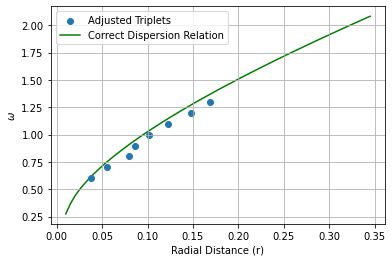

In [396]:
plt.scatter( selected_values  , omega_levels, label = 'Adjusted Triplets')

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [218]:
at_w[0]

1.75

In [304]:
c = np.argmin(np.abs(disp_ww_for_theta - 1.75))
c

50

In [220]:
disp_ww_for_theta[50]

1.7574284715139816

In [221]:
disp_r[50]

0.25999999999999995

In [222]:
j = np.argmin(np.abs(multiple_thresh_triplet_disrtibution(np.array([1.75]), lots_threshold)  - disp_r[c] ))
j

1

In [223]:
thingy[j]

0.2851912833729979

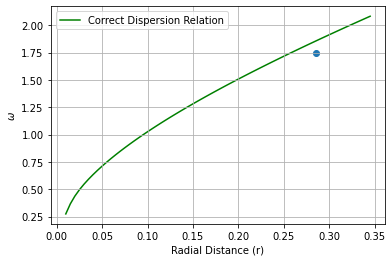

In [224]:
plt.scatter(thingy[j], 1.75)

plt.plot(disp_r,disp_ww_for_theta, color='green',zorder=0, label = 'Correct Dispersion Relation')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.legend()

In [119]:
spec3d.w[len(t)//2 + i]

1.7488199104983178

In [122]:
spec3d.kx

array([-0.41887902, -0.40618572, -0.39349241, -0.38079911, -0.36810581,
       -0.3554125 , -0.3427192 , -0.33002589, -0.31733259, -0.30463929,
       -0.29194598, -0.27925268, -0.26655938, -0.25386607, -0.24117277,
       -0.22847947, -0.21578616, -0.20309286, -0.19039955, -0.17770625,
       -0.16501295, -0.15231964, -0.13962634, -0.12693304, -0.11423973,
       -0.10154643, -0.08885313, -0.07615982, -0.06346652, -0.05077321,
       -0.03807991, -0.02538661, -0.0126933 ,  0.        ,  0.0126933 ,
        0.02538661,  0.03807991,  0.05077321,  0.06346652,  0.07615982,
        0.08885313,  0.10154643,  0.11423973,  0.12693304,  0.13962634,
        0.15231964,  0.16501295,  0.17770625,  0.19039955,  0.20309286,
        0.21578616,  0.22847947,  0.24117277,  0.25386607,  0.26655938,
        0.27925268,  0.29194598,  0.30463929,  0.31733259,  0.33002589,
        0.3427192 ,  0.3554125 ,  0.36810581,  0.38079911,  0.39349241,
        0.40618572])

In [100]:
import numpy as np

# Assuming disp_ww_for_theta is defined somewhere in your code
disp_ww_for_theta = [...]  # Replace [...] with the actual values

def find_threshold_closest_to_value(target_value, at_w, disp_ww_for_theta):
    best_threshold = None
    min_difference = float('inf')

    for threshold in np.linspace(start_threshold, end_threshold, num_steps):
        # Calculate multiple_thresh_triplet_disrtibution for the current threshold
        result = multiple_thresh_triplet_disrtibution(at_w, threshold)

        # Find the index i where disp_ww_for_theta[i] is closest to the target value
        i = np.argmin(np.abs(disp_ww_for_theta - target_value))

        # Calculate the absolute difference
        difference = np.abs(result - i)

        # Update best_threshold if the current difference is smaller
        if difference < min_difference:
            min_difference = difference
            best_threshold = threshold

    return best_threshold

# Example usage
target_value = 1.75
at_w = np.array([1.75])
start_threshold = 0.0
end_threshold = 1.0
num_steps = 100

best_threshold = find_threshold_closest_to_value(target_value, at_w, disp_ww_for_theta)

print("Best Threshold:", best_threshold)


TypeError: 'numpy.float64' object is not iterable

In [64]:
avg_k, k_above_energy = use_triplet_disrtibution(np.array([1.75]), np.array([1.4]))

In [65]:
k_above_energy

array([[0.20663201, 0.3410698 ]])

In [66]:
kx_s = [index[0]

SyntaxError: unexpected EOF while parsing (<ipython-input-66-ec328d00a378>, line 1)

In [67]:
        indices = find_indices_thresh(energies, threshold)
        # threshold energy value 
        
        kx_s = [index[0] for index in indices]
        ky_s = [index[1] for index in indices]
        
        k_above_energy = np.sqrt( spec3d.kx[kx_s]**2 + spec3d.ky[ky_s]**2 )
        
        avg_k.append(sum(k_above_energy)/len(k_above_energy))

NameError: name 'threshold' is not defined

In [35]:
use_triplet_disrtibution(1.75, np.array([0.1]))

TypeError: 'float' object is not iterable

In [36]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if isinstance(threshold, list):
                # Check if threshold is a list
                if len(threshold) == len(array[i]) and array[i][j] > threshold[j]:
                    indices.append((i, j))
            else:
                # If threshold is a single value, compare it to the element in array
                if array[i][j] > threshold:
                    indices.append((i, j))
    return indices


In [37]:
i = np.argmin(np.abs(spec3d.w[len(t)//2:] - 1.75))
        # nearest frequency to at_w
        
energies = FFT_spec[len(t)//2+i,:,:]
        # energies corresponding to kx,ky at frequecny at_W


In [38]:
indices = find_indices_thresh(energies, 0.5)
# threshold energy value 

In [39]:
indices

[(14, 42),
 (19, 50),
 (20, 51),
 (21, 51),
 (21, 52),
 (22, 52),
 (24, 54),
 (25, 54),
 (25, 55),
 (26, 55),
 (27, 55),
 (27, 56),
 (31, 57),
 (32, 57),
 (32, 58),
 (34, 58),
 (35, 58),
 (36, 58),
 (37, 58),
 (38, 58),
 (39, 58),
 (40, 58),
 (41, 58),
 (42, 58),
 (43, 58)]

In [40]:
indices

[(14, 42),
 (19, 50),
 (20, 51),
 (21, 51),
 (21, 52),
 (22, 52),
 (24, 54),
 (25, 54),
 (25, 55),
 (26, 55),
 (27, 55),
 (27, 56),
 (31, 57),
 (32, 57),
 (32, 58),
 (34, 58),
 (35, 58),
 (36, 58),
 (37, 58),
 (38, 58),
 (39, 58),
 (40, 58),
 (41, 58),
 (42, 58),
 (43, 58)]

In [41]:
np.abs(avg_k - disp_r)

ValueError: operands could not be broadcast together with shapes (1,2) (68,) 

In [42]:
def find_indices_thresh(array, threshold):
    indices = []
    for i in range(len(array)):
        for j in range(len(array[i])):
            if isinstance(threshold, list):
                # Check if threshold is a list
                if len(threshold) == len(array[i]) and array[i][j] > threshold[j]:
                    indices.append((i, j))
            else:
                # If threshold is a single value, compare it to the element in array
                if array[i][j] > threshold:
                    indices.append((i, j))
    return indices


In [43]:
array_2d = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
threshold_value = 6

result = find_indices_thresh(array_2d, threshold_value)
print(result)


[(2, 0), (2, 1), (2, 2)]


In [44]:
array_2d = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
threshold_list = [3, 6, 8]

result = find_indices_thresh(array_2d, threshold_list)
print(result)


[(1, 0), (2, 0), (2, 1), (2, 2)]
